### Project: Titanic dataset

### Author: Ricardo A. Leal

#### Problem: predict which passengers survived the Titanic shipwreck using the dataset from the Kaggle competition "Titanic: Machine Learning from Disaster"

##### Note: 
Some of my features are processed in a similar way to what I have learn on different machine learning courses, books and websites. This is a basic project to get familiar with machine learning techniques.

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

#ML models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
#Set seed to reproduce results
np.random.seed(33)
#Ignore warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Get the data

In [2]:
#READING DATA
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

## Exploring and preparing the data

In [3]:
#Explore data
print("Train info:\n")
train_set.info()

print("\n\nTest info:\n")
test_set.info()

Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Test info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-nu

We can see that there is not much information missing. We will drop some of the columns and replace missing values in other columns.

##### Dropping Cabin, Ticket and PassengerId columns

In [4]:
#Drop Cabin column
train_set = train_set.drop(['Cabin'], axis = 1)
test_set = test_set.drop(['Cabin'], axis = 1)

#Drop Ticket column
train_set = train_set.drop(['Ticket'], axis = 1)
test_set = test_set.drop(['Ticket'], axis = 1)

#Drop PassengerId column but keep a copy of the test set's passengerId for the submission
train_set = train_set.drop(['PassengerId'], axis = 1)
test_passenger_id = test_set['PassengerId'].copy() #Copy for the submission
test_set = test_set.drop(['PassengerId'], axis = 1)

##### Age column

In [5]:
#Replace missing values in the Age column with the mean age of each set
age_mean = round(train_set['Age'].mean())
train_set['Age'] = train_set['Age'].fillna(age_mean)
test_set['Age'] = test_set['Age'].fillna(age_mean)

##### Sex column

In [6]:
#Replace categorical values in the Sex column for numerical values
train_set['Sex'].replace({'female': 0, 'male': 1}, inplace = True)
test_set['Sex'].replace({'female': 0, 'male': 1}, inplace = True)

##### Embarked column

In [7]:
#Replace categorical values in the Embarked column for numerical values
train_set['Embarked'].replace({'C': 0, 'S': 1, 'Q':2}, inplace = True)
test_set['Embarked'].replace({'C': 0, 'S': 1, 'Q':2}, inplace = True)

#See the passengers that are missing the Embarked value
print(train_set.loc[train_set['Embarked'].isnull()])

     Survived  Pclass                                       Name  Sex   Age  \
61          1       1                        Icard, Miss. Amelie    0  38.0   
829         1       1  Stone, Mrs. George Nelson (Martha Evelyn)    0  62.0   

     SibSp  Parch  Fare  Embarked  
61       0      0  80.0       NaN  
829      0      0  80.0       NaN  


Both of those passengers belong to the 1st class and have a higher chance of survival.
Instead of dropping them, I will replace the missing value with the mode of the Embarked column in the train set

In [8]:
#Find the mode of the column
embarked_mode = train_set['Embarked'].mode()

#Replace values with the mode
train_set['Embarked'].replace({np.NaN: embarked_mode.iloc[0] }, inplace = True)

##### Fare column

In [9]:
#See which values are NaN
print(test_set.loc[test_set['Fare'].isnull()])

     Pclass                Name  Sex   Age  SibSp  Parch  Fare  Embarked
152       3  Storey, Mr. Thomas    1  60.5      0      0   NaN         1


Only one person is missing the Fare value in the test set. As the test set is very small, I will not drop that passenger. Instead, I will reaplce the value with the mean of the Fare column.

In [10]:
#Make a copy of the data
temp_data = test_set.copy()
#Check the average price for Pclass == 3
temp_data = temp_data[temp_data['Pclass'] == 3]

#Find the mean
mean_fare = round(temp_data['Fare'].mean())
#Replace missing values with the mean
test_set['Fare'].replace({np.NaN: mean_fare }, inplace = True)

##### Name column

In [11]:
#Explore data
print('Column Name has',train_set['Name'].value_counts().sum(),'unique values')
print('It is better to get the titles of the passengers instead of the full names')

Column Name has 891 unique values
It is better to get the titles of the passengers instead of the full names


The Name column values will be divided into smaller groups based on their social status/title. This process will
be done for both the training and test set.

In [12]:
#Replacing names in the train set:

#Make a copy of the train set
split_train_names = train_set['Name'].copy()

#Divide the string fom left to right
split_train_names = split_train_names.str.split(", ", n=1, expand = True) #Separate the last name and the title
split_train_names = split_train_names.drop([0], axis = 1) #Drop the last name
split_train_names[1] = split_train_names[1].str.split(".", n=1, expand = True) #Get only the title

#Change the titles to numbers
split_train_names[1].replace({'Mr': 0, 'Mrs': 0, 'Ms': 0}, inplace = True)
split_train_names[1].replace({'Rev': 1, 'Miss': 1, 'Mlle':1, 'Major': 1, 'Mme':1}, inplace = True)
split_train_names[1].replace({'Master': 2, 'Col': 2, 'Capt': 2, 'Dr': 2}, inplace = True)
split_train_names[1].replace({'the Countess': 3, 'Don': 3, 'Jonkheer':3, 'Sir': 3, 'Lady': 3, 'Dona': 3}, inplace = True)

#Copy column to train set
train_set['Name'] = split_train_names[1].copy()

Same replacing process for the names in the test set:

In [13]:
#Make a copy
split_test_names = test_set['Name'].copy()

#Divide the string fom left to right characters
split_test_names = split_test_names.str.split(", ", n=1, expand = True)#Separate the last name and the title
split_test_names = split_test_names.drop([0], axis = 1)#Drop the last name
split_test_names[1] = split_test_names[1].str.split(".", n=1, expand = True) #Get only the title

#Change the titles to numbers
split_test_names[1].replace({'Mr': 0, 'Mrs': 0, 'Ms': 0}, inplace = True)
split_test_names[1].replace({'Rev': 1, 'Miss': 1, 'Mlle':1, 'Major': 1, 'Mme':1}, inplace = True)
split_test_names[1].replace({'Master': 2, 'Col': 2, 'Capt': 2, 'Dr': 2}, inplace = True)
split_test_names[1].replace({'the Countess': 3, 'Don': 3, 'Jonkheer':3, 'Sir': 3, 'Lady': 3, 'Dona': 3}, inplace = True)

#Copy column to test set
test_set['Name'] = split_test_names[1].copy()

##### Creating another feature 'FamilyOnboard'

In [14]:
#Create a new feature 'Family on-board' combining the SibSp and Parch columns
#Adding the values together
train_set['FamilyOnboard'] = train_set['SibSp'] + train_set['Parch']
test_set['FamilyOnboard'] = test_set['SibSp'] + test_set['Parch']

#Drop the SibSp column as it is no longer needed
train_set = train_set.drop(['SibSp'], axis = 1)
test_set = test_set.drop(['SibSp'], axis = 1)

#Drop the Parch column as it is no longer needed
train_set = train_set.drop(['Parch'], axis = 1)
test_set = test_set.drop(['Parch'], axis = 1)

### Scaling and organizing the data

Feature scaling to a range between 0 to 1 using MinMaxScaler for all features

In [15]:
print(train_set.shape)
print(test_set.shape)

(891, 8)
(418, 7)


In [16]:
#Scaling the train set
scaler = MinMaxScaler()
scaled_train_set_array = scaler.fit_transform(train_set)
#Convert into a dataframe
scaled_train_set = pd.DataFrame(scaled_train_set_array)

#Scaling the test set
scaler2 = MinMaxScaler()
scaled_array = scaler2.fit_transform(test_set) 

#Convert into a dataframe
scaled_test_set = pd.DataFrame(scaled_array)

In [17]:
#Adding column names to the sets
#Train set
scaled_train_set.columns = ['Survived','Pclass','Name','Sex','Age','Fare','Embarked','FamilyOnboard']
#Test set
scaled_test_set.columns = ['Pclass','Name','Sex','Age','Fare','Embarked','FamilyOnboard']

In [18]:
#Separate the Survived labels from the training set to avoid leaks
survived_train = scaled_train_set['Survived'].copy()
scaled_train_set = scaled_train_set.drop(['Survived'], axis = 1)

Now the data is scaled and both sets have the same number of columns. We are ready to create our models

## Machine Leaning models

In [19]:
#Machine learning models for classification tasks:

#LogisticRegression
logistic_model = LogisticRegression()
#SGDClassifier
sgd_model = SGDClassifier()
#SVM ALGORITHM
svc_model = SVC()

Loop to fit the data and measure the performance of each model. We will measure the performance using the Confusion matrix, and F1 score

In [20]:
for model in (logistic_model, sgd_model, svc_model):
    #Print model name
    print("\nModel : ", model.__class__.__name__)
    
    #Fit the data
    model.fit(scaled_train_set, survived_train) 
    
    #Get CrossVal results
    cross_val_result = cross_val_predict(model, scaled_train_set, survived_train, cv=3)
    
    #Create a confusion matrix with the results from CrossVal
    print("\nConfusion matrix for the cross val prediction:")
    print(confusion_matrix(survived_train, cross_val_result))
    
    #Measure the F1 score
    print("\nF1 score:", f1_score(survived_train, cross_val_result))
    #Separator line to make the output more readable
    print("############################")   
#End of loop


Model :  LogisticRegression

Confusion matrix for the cross val prediction:
[[473  76]
 [110 232]]

F1 score: 0.7138461538461539
############################

Model :  SGDClassifier

Confusion matrix for the cross val prediction:
[[485  64]
 [122 220]]

F1 score: 0.7028753993610224
############################

Model :  SVC

Confusion matrix for the cross val prediction:
[[507  42]
 [126 216]]

F1 score: 0.72
############################


After checking the results, we can see that all models have similar performances. However, the SVC  model performs the best.


## Improve the models

We will plot Precision vs Recall to find the best tresholds for our goal


Model:  LogisticRegression


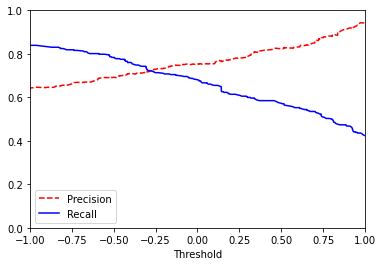


Model:  SGDClassifier


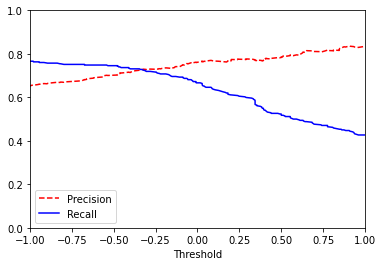


Model:  SVC


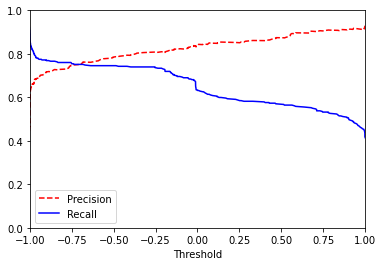

In [21]:
for model in (logistic_model, sgd_model, svc_model):
    print("\nModel: ", model.__class__.__name__)

    #Cross validation
    survived_scores = cross_val_predict(model, scaled_train_set, survived_train, cv=3,method="decision_function")
    #Get data for the graph
    precisions, recalls, thresholds = precision_recall_curve(survived_train, survived_scores)
  
    #Plot data
    plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.xlim(-1,1)
    plt.ylim(0, 1) 
    plt.show()

##### Now with this thresholds we will aim to get a precision of about 80% and a good F1 score. 

In [22]:
for model in (logistic_model, sgd_model, svc_model):
    #Print model name
    print("\nModel: ", model.__class__.__name__)

    #Cross validation
    survived_scores = cross_val_predict(model, scaled_train_set, survived_train, cv=3,method="decision_function")
    
    #Convert results into a dataframe
    survived_train_pred = pd.DataFrame(survived_scores)
    
    #Appliying the best threshold for each model
    if(model == logistic_model):
        survived_train_pred  = (survived_scores > 0.13)   
    elif(model == sgd_model):
                survived_train_pred  = (survived_scores > 0.25) 
    elif(model == svc_model):
                survived_train_pred  = (survived_scores > -0.25)
    
    #Avoiding a mix of binary and continuous targets
    survived_train = survived_train.astype(bool)
    survived_train_pred = survived_train_pred.astype(bool)
    
    #Check preformance with the new thresholds
    print('\nPrecicion score:', precision_score(survived_train, survived_train_pred))
    print("\nF1 score:", f1_score(survived_train, survived_train_pred))
    print('\nRecall score:', recall_score(survived_train, survived_train_pred))
    print('\nConfusion matrix:\n', confusion_matrix(survived_train, survived_train_pred))
    #Separator line to make the output more readable
    print("############################")


Model:  LogisticRegression

Precicion score: 0.7681660899653979

F1 score: 0.7036450079239303

Recall score: 0.6491228070175439

Confusion matrix:
 [[482  67]
 [120 222]]
############################

Model:  SGDClassifier

Precicion score: 0.7541528239202658

F1 score: 0.7060653188180404

Recall score: 0.6637426900584795

Confusion matrix:
 [[475  74]
 [115 227]]
############################

Model:  SVC

Precicion score: 0.8070739549839229

F1 score: 0.7687595712098009

Recall score: 0.7339181286549707

Confusion matrix:
 [[489  60]
 [ 91 251]]
############################


We can see that the SVC model performed best after appliying the threshold. Therefore, we will use that model with the test set

## Test the best model

In [23]:
#Choosing the best model to predict the test set
survived_prediction = svc_model.decision_function(scaled_test_set) #SVC model performed best

#Applying the best threshold
survived_prediction = (survived_prediction > -0.25)

#Convert predictions into a dataframe
submission = pd.DataFrame(survived_prediction)

#Insert PassengerId column to the predictions
submission.insert(1, 'PassengerId', test_passenger_id)

#Add names to columns
submission.columns = ['Survived', 'PassengerId']
#Convert data from bool to int
submission['Survived'].replace({False: 0, True: 1}, inplace = True)

#Print results of model
print("The SVC model predicts that about", int(submission['Survived'].mean() * 100), "% of the passengers survived")

#Save predictions to a CSV file
#submission.to_csv('predictions.cvs', index = False)

The SVC model predicts that about 38 % of the passengers survived
